## Chiptune Generation Project Sandbox

Notebook for trying out some code in an interactive, sandbox-like environment.

In [1]:
from modules import mcc_parser, mcc_markov, mcc_waves, mcc_builder

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

sr = 44100

In [3]:
"""
Single track example.
"""

# Open the MidiFile.
mid = mcc_parser.open_midi("data/Zgbreve.mid")
# Extract attributes such as tempo and time signature from header track.
info = mcc_parser.extract_midi_info(mid.tracks[0])
tracks = mcc_parser.extract_midi_tracks(mid.tracks)

# First track.
track = mcc_parser.midi_to_rtttl(tracks[0], mid.ticks_per_beat)

# Train and predict.
mm = mcc_markov.KMarkov(3)
mm.fit(track)
# Passing the track we just trained on allows us to control the starting note of prediction.
gen = mm.predict(samples=50, priors=track)

# Join the original notes with the generated notes.
full = mcc_builder.join(track, ",", gen)

# Render the notes as a waveform.
res = mcc_waves.notes_to_waveform(full, bpm=info["tempo"][0], wave_function=mcc_waves.triangle_wave)

In [5]:
# ipd.Audio(res, rate=sr)

In [4]:
res = mcc_waves.notes_to_waveform(track, bpm=info["tempo"][0], wave_function=mcc_waves.triangle_wave)
# ipd.Audio(res, rate=sr)

In [3]:
"""
Multi-track example. Specify out_type: 0=original, 1=generated, 2(orelse)=concatenated.
"""

def create_multitrack(fname, out_type=0):
    # Open the MidiFile.
    mid = mcc_parser.open_midi(fname)
    # Extract attributes such as tempo and time signature from header track.
    info = mcc_parser.extract_midi_info(mid.tracks[0])
    tracks = mcc_parser.extract_midi_tracks(mid.tracks)
    
    output_tracks = []

    for track in tracks:
        track = mcc_parser.midi_to_rtttl(track, mid.ticks_per_beat)

        # Train and predict.
        mm = mcc_markov.KMarkov(30)
        mm.fit(track)
        gen = mm.predict(50)

        # Join the original notes with the generated notes.
        full = mcc_builder.join(track, ",", gen)

        # Render the notes as a waveform.
        if out_type == 0:
            res = mcc_waves.notes_to_waveform(track, bpm=info["tempo"][0], wave_function=mcc_waves.triangle_wave)
        elif out_type == 1:
            res = mcc_waves.notes_to_waveform(gen, bpm=info["tempo"][0], wave_function=mcc_waves.triangle_wave)
        else:    
            res = mcc_waves.notes_to_waveform(full, bpm=info["tempo"][0], wave_function=mcc_waves.triangle_wave)
        
        output_tracks.append(res)

    # TODO: this track combination does not line up the 
    # tracks correctly. Results in tracks out of sync.
    return mcc_builder.combine_tracks(output_tracks)

In [6]:
# Output wavs of the original and generated 
in_song = "data/Zgbreve.mid"
mcc_builder.export_to_wav(create_multitrack(song, 0), sr, "zgbreve_org")
mcc_builder.export_to_wav(create_multitrack(song, 1), sr, "zgbreve_gen")

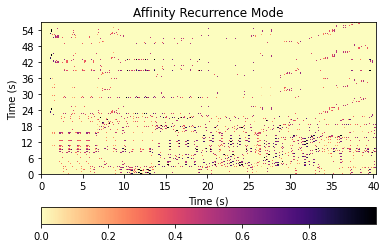

In [7]:
import librosa
import librosa.display

org, org_sr = librosa.load("out/zgbreve_org.wav")
gen, gen_sr = librosa.load("out/zgbreve_gen.wav")

mfcc_org = librosa.feature.mfcc(y=org, sr=gen_sr)
mfcc_gen = librosa.feature.mfcc(y=gen, sr=org_sr)

xsim = librosa.segment.cross_similarity(mfcc_org, mfcc_gen, mode="affinity", metric="cosine")

img = librosa.display.specshow(xsim, x_axis="s", y_axis="s", cmap="magma_r")

plt.title("Affinity Recurrence Mode")
plt.colorbar(img, orientation="horizontal")
plt.show()